##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Magnetometria - Amplitude do Sinal Analítico

####Referencia:
#####• Szameitat, L.S.A., Bongiolo, A.B.S. 2024. RECURSOS COMPUTACIONAIS PARA REALCE DE ANOMALIAS MAGNETOMÉTRICAS E GRAVIMÉTRICAS EM SALA DE AULA. Boletim Paranaense de Geociências.

####Agradecimentos
Este trabalho foi beneficiado pelas discussões com o Geól. Julio Lyrio (Petrobras) e o Físico Erico Saito Szameitat (Pólícia Científica do Paraná), aos quais as autoras agradecem pela colaboração.

####Outras Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.
#####• Bongiolo, A. B. S., de Souza, J., Ferreira, F. J. F., & de Castro, L. G. (2013). Grav mag prism: A MATLAB/octave program to generate gravity and magnetic anomalies due to rectangular prismatic bodies. Brazilian Journal of Geophysics, 31(3), 347-363.

Importar bibliotecas

In [1]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt, atan
import matplotlib.pyplot as plt
import pandas as pd

##Funções
Funções para trabalhar com os dados do campo magnético anômalo, adaptadas de Blakely (1996).

In [2]:
def DirCos(i, d, az):
    '''
    Parametros
    ----------
    i - inclinacao
    d - declinacao
    az - azimute
    '''
    a = cos(radians(i))*cos(radians(d)-radians(az))
    b = cos(radians(i))*sin(radians(d)-radians(az))
    c = sin(radians(i))
    return a, b, c

def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Parametros
    ----------
    i, j - indices
    nx, ny -  numero de amostras em x e y
    dkx, dky -
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1
    kx = float()
    ky = float()
    if j <= nyqx:
        kx = (j-1) * dkx
    else:
        kx = (j-nx-1) * dkx
    if i <= nyqy:
        ky = (i-1) * dky
    else:
        ky = (i-ny-1) * dky
    return kx, ky

def Derivada(vetor, axis, nx, ny, dkx, dky):
    # FFT, entrada grid de 2 dimensões
    grid = np.reshape(vetor, (ny, nx)) #de 1D para 2D
    gridfft = scipy.fftpack.fft2(grid)
    # Grid - de matriz para vetor
    gridfft = np.reshape(gridfft, ny*nx)
    # Cria um vetor complexo
    gridfft_filt = np.zeros(ny*nx).astype(complex)
    if axis == 'z':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = sqrt(kx**2 + ky**2)
                gridfft_filt[ij-1] = gridfft[ij-1]*k**1 #filtro
    elif axis == 'y':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = kx
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    elif axis == 'x':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = ky
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    else:
        return print ('Tipo não suportado: ', axis)

    #iFFT, entrada como matriz 2D
    gridfft_filt = np.reshape(gridfft_filt, (ny, nx))
    gridfft_filt = scipy.fftpack.ifft2(gridfft_filt)
    #retorna para 1D, para saida como vetor
    vetor_out = np.reshape(gridfft_filt.real, (ny*nx))

    return vetor_out



##Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo. O arquivo de exemplo contém uma anomalia dipolar referente ao levantamento magnetométrico realizado no sítio controlado do LPGA-UFPR (Bongiolo et al., 2022)

In [3]:
#Opção 1 - Arquivo para exercício

#Anomalia do campo magnético adquirida no Sítio Controlado LPGA-UFPR (Bongiolo et al., 2022)
arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_mag/gravmagprisma.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io
#uploaded=files.upload()
#arquivo = '  '#inserir o nome do arquivo nesta variável

dados = pd.read_csv(arquivo, header = 0, delimiter = ",")
dados

,LESTE,NORTE,MAG,GRAV
0,0.0,0.0,-171.271,0.222
1,10.0,0.0,-181.490,0.231
2,20.0,0.0,-191.876,0.240
3,30.0,0.0,-202.339,0.249
4,40.0,0.0,-212.772,0.259
...,...,...,...,...
2596,460.0,500.0,-194.981,0.259
2597,470.0,500.0,-183.071,0.249
2598,480.0,500.0,-171.406,0.240
2599,490.0,500.0,-160.070,0.231


Abrir e visualizar o arquivo de entrada:

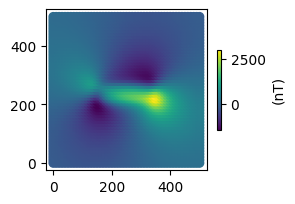

In [4]:
#Plotar
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_mag = plt.scatter(dados.LESTE, dados.NORTE, c=dados.MAG, cmap='viridis')
plt.colorbar(entrada_mag, label="(nT)", shrink=0.3) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

### Organizando os grids de entrada (leste, norte, campo mag)

In [5]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_CMA = dados.MAG.to_numpy()

#Elementos a leste e a norte
pontos_LESTE=[]
pontos_NORTE=[]

#Adicionar valores não repetidos
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
n_l = np.size(pontos_LESTE)
n_n = np.size(pontos_NORTE)

#Obter a distancia em x e y
dX, dY = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])

#Grid
grid_LESTE, grid_NORTE = np.meshgrid(pontos_LESTE, pontos_NORTE) #mesh
grid_CMA = np.reshape(vetor_CMA, (n_n, n_l)) #de 1D para 2D

#Salva as posições dos prismas como array
pontos_LESTE = np.array(pontos_LESTE)
pontos_NORTE = np.array(pontos_NORTE)


# Filtro amplitude do sinal anaílitico (ASA)

Definir parâmetros e aplicar a transformação no dado

In [9]:
#Salvar número de itens a leste e a norte
nx = np.size(pontos_LESTE)
ny = np.size(pontos_NORTE)

#Definir parâmetros
π = np.pi
dkx = 2. * π / (nx * dX)
dky = 2. * π / (ny * dY)

# Filtros Derivadas()
vetor_DX1 = Derivada(vetor_CMA, 'x', nx, ny, dkx, dky)
vetor_DY1 = Derivada(vetor_CMA, 'y', nx, ny, dkx, dky)
vetor_DZ1 = Derivada(vetor_CMA, 'z', nx, ny, dkx, dky)

#Adicionar no dataframe
dados = dados.assign(DX1 = vetor_DX1)
dados = dados.assign(DY1 = vetor_DY1)
dados = dados.assign(DZ1 = vetor_DZ1)
dados

,LESTE,NORTE,MAG,GRAV,DX1,DY1,DZ1
0,0.0,0.0,-171.271,0.222,-24.762598,-18.958245,-37.086307
1,10.0,0.0,-181.490,0.231,9.518959,-19.593888,-21.905561
2,20.0,0.0,-191.876,0.240,-7.708182,-20.189772,-23.995315
3,30.0,0.0,-202.339,0.249,3.810928,-20.732785,-23.065467
4,40.0,0.0,-212.772,0.259,-4.863460,-21.208997,-23.917624
...,...,...,...,...,...,...,...
2596,460.0,500.0,-194.981,0.259,3.923466,26.020826,-29.459835
2597,470.0,500.0,-183.071,0.249,-2.276592,25.227727,-28.170307
2598,480.0,500.0,-171.406,0.240,5.891121,24.384019,-27.957863
2599,490.0,500.0,-160.070,0.231,-6.381737,23.504016,-25.414670


In [10]:
grid_DX1 = np.reshape(vetor_DX1, (n_n, n_l)) #de 1D para 2D
grid_DY1 = np.reshape(vetor_DY1, (n_n, n_l)) #de 1D para 2D
grid_DZ1 = np.reshape(vetor_DZ1, (n_n, n_l)) #de 1D para 2D

grid_ASA = np.sqrt((grid_DX1**2)+(grid_DY1**2)+(grid_DZ1**2))

dados = dados.assign(ASA = np.reshape(grid_ASA, (n_l*n_n)))
dados

,LESTE,NORTE,MAG,GRAV,DX1,DY1,DZ1,ASA
0,0.0,0.0,-171.271,0.222,-24.762598,-18.958245,-37.086307,48.456119
1,10.0,0.0,-181.490,0.231,9.518959,-19.593888,-21.905561,30.893117
2,20.0,0.0,-191.876,0.240,-7.708182,-20.189772,-23.995315,32.292694
3,30.0,0.0,-202.339,0.249,3.810928,-20.732785,-23.065467,31.247197
4,40.0,0.0,-212.772,0.259,-4.863460,-21.208997,-23.917624,32.334618
...,...,...,...,...,...,...,...,...
2596,460.0,500.0,-194.981,0.259,3.923466,26.020826,-29.459835,39.501378
2597,470.0,500.0,-183.071,0.249,-2.276592,25.227727,-28.170307,37.883865
2598,480.0,500.0,-171.406,0.240,5.891121,24.384019,-27.957863,37.562318
2599,490.0,500.0,-160.070,0.231,-6.381737,23.504016,-25.414670,35.200437


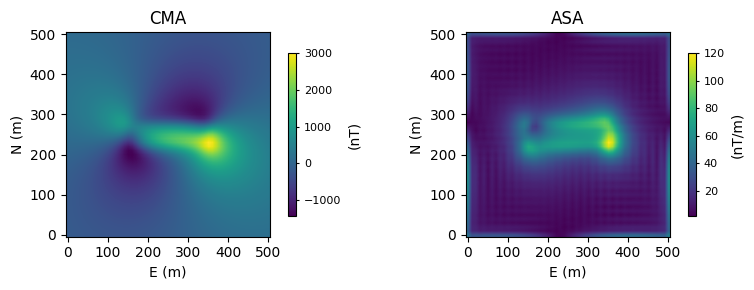

In [11]:
#Exibir mapas do dado de entrada e de saída
plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.title("CMA")
mapa_cma = plt.imshow(grid_CMA, interpolation='bilinear', cmap='viridis')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_cma = plt.colorbar(mapa_cma, label="(nT)", shrink=0.8)
colorbar_cma.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_cma.ax.tick_params(labelsize=8)  # define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.xticks(range(0, len(pontos_LESTE), 10), [int(round(val, 0)) for val in pontos_LESTE[::10]])  # intervalo de 10 em 10 valores, 0 casas decimais
plt.yticks(range(0, len(pontos_NORTE), 10), [int(round(val, 0)) for val in pontos_NORTE[::10]])
plt.xlabel('E (m)')
plt.ylabel('N (m)')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("ASA")
mapa_asa = plt.imshow(grid_ASA, interpolation='bilinear', cmap='viridis')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
colorbar_asa = plt.colorbar(mapa_asa, label="(nT/m)", shrink=0.8)
colorbar_asa.ax.yaxis.set_tick_params(size=2)
colorbar_asa.ax.tick_params(labelsize=8)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(0, len(pontos_LESTE), 10), [int(round(val, 0)) for val in pontos_LESTE[::10]])
plt.yticks(range(0, len(pontos_NORTE), 10), [int(round(val, 0)) for val in pontos_NORTE[::10]])
plt.xlabel('E (m)')
plt.ylabel('N (m)')
plt.tight_layout()

#Salvar figura
plt.savefig('mag_asa-baixalat_gravmagprism_py.png', dpi=300, bbox_inches='tight')

plt.show()

Salvar a saída como arquivo csv

In [ ]:
dados.to_csv("mag_asa-baixalat_gravmagprism_py.csv")